In [ ]:
import os
import json
from collections import Counter
from collections import defaultdict
import glob
import re
from tqdm import tqdm

from paddlenlp import Taskflow
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import hstack

d:\Studies\HSE\project\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
d:\Studies\HSE\project\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# NER

In [2]:
def extract_entity_mentions_with_positions(folder_path, output_folder='ner_texts_mentions'):
    ner = Taskflow("information_extraction", schema=["人名"])
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()

        result = ner(text)

        mentions = []
        for entry in result:
            for entity_type, values in entry.items():
                for item in values:
                    mentions.append({
                        "entity": item["text"],
                        "start": item["start"],
                        "end": item["end"],
                        "type": entity_type
                    })

        output_file = os.path.join(output_folder, f"{filename}.json")
        with open(output_file, "w", encoding='utf-8') as outfile:
            json.dump({
                "filename": filename,
                "mentions": mentions
            }, outfile, ensure_ascii=False, indent=2)
        
        print(f"{output_file} created successfully.")

In [3]:
folder_path = r"D:\Studies\HSE\project\texts"
extract_entity_mentions_with_positions(folder_path)

[2025-04-27 16:46:48,486] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.tokenizer.ErnieTokenizer'> to load 'C:\Users\soule\.paddlenlp\taskflow\information_extraction\uie-base'.
d:\Studies\HSE\project\.venv\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:2478: FutureWarning: The `max_seq_len` argument is deprecated and will be removed in a future version, please use `max_length` instead.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:1878: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ner_texts_mentions\一级律师[星际].txt.json created successfully.
ner_texts_mentions\三生三世十里桃花 by 唐七公子.txt.json created successfully.
ner_texts_mentions\三生三世枕上书——唐七公子.txt.json created successfully.
ner_texts_mentions\二哈和他的白猫师尊.txt.json created successfully.
ner_texts_mentions\人渣反派自救系统.txt.json created successfully.
ner_texts_mentions\他来了请闭眼.txt.json created successfully.
ner_texts_mentions\你是我的小确幸_御风九尧.txt.json created successfully.
ner_texts_mentions\全职高手_蝴蝶蓝.txt.json created successfully.
ner_texts_mentions\凰权_天下归元.txt.json created successfully.
ner_texts_mentions\千秋.txt.json created successfully.
ner_texts_mentions\后宫：甄嬛传1.txt.json created successfully.
ner_texts_mentions\君九龄.txt.json created successfully.
ner_texts_mentions\天官赐福.txt.json created successfully.
ner_texts_mentions\嫡嫁千金.txt.json created successfully.
ner_texts_mentions\将夜_猫腻【完结】.txt.json created successfully.
ner_texts_mentions\延禧攻略.txt.json created successfully.
ner_texts_mentions\恶魔少爷别吻我.txt.json created successfully.
ner_te

# Coreference Resolution (пока без местоимений!)

In [ ]:
def build_unique_entity_list(json_folder):
    counter = Counter()

    for filepath in glob.glob(f"{json_folder}/*.json"):
        with open(filepath, encoding='utf-8') as f:
            data = json.load(f)

            for mention in data["mentions"]:
                if mention["type"] == "人名":
                    counter[mention["entity"]] += 1

    unique_entities = [{"entity": ent, "count": count} for ent, count in counter.items() if len(ent) < 8]
    return unique_entities

texts_with_ner_mentions = r"D:\Studies\HSE\project\ner_texts_mentions"
# получаем список именованных сущностей с кол-вом упоминаний
unique_entities_list = build_unique_entity_list(texts_with_ner_mentions)

In [30]:
print(len(unique_entities_list))
unique_entities_list[0]

10549


{'entity': '燕绥之', 'count': 4225}

In [ ]:
def string_similarity(a: str, b: str) -> float:
    return SequenceMatcher(None, a, b).ratio()

def is_valid_entity(entity: str, max_len=10, min_freq=2, bad_keywords=None, min_len=2) -> bool:
    if bad_keywords is None:
        bad_keywords = ["房东", "男人", "女人", "小孩", "父亲", "仆人", "老师"]
    if len(entity) < min_len:
        return False
    if len(entity) > max_len and not entity.isascii():
        return False
    for word in bad_keywords:
        if word in entity:
            return False
    return True

def cluster_entities_by_similarity(entity_list, name_sim_threshold=0.9):
    """
    Кластеризация имен по правилам:
      – Префиксное совпадение при расстоянии <= 500 символов
      – Однослоговый постфикс для двуслоговых имен при расстоянии <= 500
      – Двуслоговый постфикс
      – Очень высокая строковая похожесть
    """
    # собираем позиции упоминаний для каждого alias, потому что сущности в списке - не уникальные!!
    name_to_positions = defaultdict(list)
    for item in entity_list:
        alias = item["alias"]
        start = item["mention_start"]
        if is_valid_entity(alias, min_freq=1, min_len=1):
            name_to_positions[alias].append(start)

    names = list(name_to_positions.keys())

    def min_pos_diff(n1, n2):
        return min(
            abs(p1 - p2)
            for p1 in name_to_positions[n1]
            for p2 in name_to_positions[n2]
        )

    def should_link(n1: str, n2: str) -> bool:
        short, long = (n1, n2) if len(n1) <= len(n2) else (n2, n1)

        pos_diff = min_pos_diff(n1, n2)

        # префикс при разнице в позициях <= 500
        if len(short) >= 1 and long.startswith(short) and pos_diff <= 500:
            return True

        # однослоговый постфикс для двуслогового имени при разнице <= 500
        if len(short) == 1 and len(long) == 2 and long.endswith(short) and pos_diff <= 500:
            return True

        # двуслоговый постфикс
        if len(short) == 2 and long.endswith(short):
            return True

        # похожесть
        if string_similarity(n1, n2) >= name_sim_threshold:
            return True

        return False

    clusters = []
    used = set()

    for name in names:
        if name in used:
            continue

        cluster = []
        queue = [name]
        used.add(name)

        while queue:
            curr = queue.pop(0)
            cluster.append(curr)
            for other in names:
                if other not in used and should_link(curr, other):
                    used.add(other)
                    queue.append(other)

        clusters.append(cluster)

    return clusters
entities_clusters = cluster_entities_by_similarity(test_character_mentions)
# entities_clusters = cluster_entities_by_similarity(unique_entities_list)
# entities_clusters

In [32]:
print(len(entities_clusters))
entities_clusters[100]

6933


['顾动产']

In [33]:
# смотрим, сколько кластеров всего
print(f"Всего кластеров: {len(entities_clusters)}")

# и сколько из них содержат 1 элемент
singleton_count = sum(1 for cluster in entities_clusters if len(cluster) == 1)
print(f"Одиночных кластеров: {singleton_count} ({singleton_count / len(entities_clusters) * 100:.2f}%)")


Всего кластеров: 6933
Одиночных кластеров: 5579 (80.47%)


In [34]:
def build_alias_dict(entity_list, clusters):
    freq_dict = {e['entity']: e['count'] for e in entity_list}
    alias_dict = {}

    for cluster in clusters:
        # выбираем самое частотное имя как "канон"
        canonical = max(cluster, key=lambda name: freq_dict.get(name, 0))
        alias_dict[canonical] = cluster

    return alias_dict

# получаем словарь всех похожих имен
entities_names_dict = build_alias_dict(unique_entities_list, entities_clusters)
len(entities_names_dict)

6933

In [35]:
entities_names_dict

{'燕绥之': ['燕绥之', '燕绥', '绥之'],
 '阮野': ['阮野'],
 '德卡马': ['德卡马'],
 '金发': ['金发'],
 '顾晏': ['顾晏', '顾晏加', '顾晏真', '顾晏言', '顾晏正'],
 '菲兹': ['菲兹', '艾琳·菲兹', '高格利·菲兹', '艾琳', '艾琳娜'],
 '莫尔': ['莫尔'],
 '亨利': ['亨利', '亨利·奥古斯都', '亨利希'],
 '艾维斯': ['艾维斯', '艾维'],
 '菲莉达': ['菲莉达'],
 '迪恩': ['迪恩'],
 '吉塔': ['吉塔'],
 '阿蒙': ['亚当斯', '亚当', '阿蒙亚当', '阿蒙', '阿蒙新'],
 '清凌凌': ['清凌凌', '凌凌'],
 '洛克': ['洛克',
  '金毛洛克',
  '夏洛克',
  '洛克哈德',
  '金毛',
  '夏洛克·莫里亚',
  '夏洛克·莫',
  '夏洛克·莫里',
  '夏洛克.莫'],
 '阿里安娜': ['安娜', '安娜·卡列尼娜', '奥利安娜', '胡安娜', '阿里安娜', '奥利安'],
 '霍布斯': ['霍布斯'],
 '约书亚': ['约书亚', '约书亚·达勒', '书亚', '达勒', '罗希·达勒', '亚·达勒', '罗希', '罗希特'],
 '管教': ['管教'],
 '曼森': ['乔治',
  '乔治·曼森',
  '乔治三世',
  '乔治·尼根',
  '乔治娜',
  '曼森',
  '查乔治·曼森',
  '尼根',
  '曼森格伦',
  '布鲁尔·曼森',
  '米罗·曼森',
  '老曼森',
  '肯·曼森',
  '米罗曼森',
  '拿曼森',
  '阿古希德·尼根',
  '帕拉斯·尼根',
  '格伦',
  '布鲁尔',
  '米罗',
  '阿古希德',
  '帕拉斯'],
 '贝尔纳黛': ['吉蒂·贝尔',
  '贝尔',
  '吉蒂',
  '吉蒂·贝',
  '吉蒂·贝尔里',
  '切斯特·贝尔',
  '贝尔纳黛',
  '希贝尔',
  '贝尔丹',
  '贝尔纳黛默',
  '诺贝尔',
  '切斯特',
  '纳黛'],
 '费克斯': ['费克斯', '费克斯·戈尔', '戈尔', '

In [ ]:
# делим на предложения для контекстного окна
def split_into_sentences(text):
    sentence_enders = re.compile(r'(?<=[。！？!?])')
    sentences = sentence_enders.split(text)
    return [s.strip() for s in sentences if s.strip()]

def invert_alias_dict(alias_dict):
    mention_to_canon = {}
    for canon, aliases in alias_dict.items():
        for alias in aliases:
            mention_to_canon[alias] = canon
    return mention_to_canon

def assign_canonical_mentions_with_sentences(
        mentions_folder, 
        alias_dict, 
        original_texts_folder, 
        output_file='character_mentions_final.jsonl'
        ):
    
    mention_to_canon = invert_alias_dict(alias_dict)
    output = []

    for path in glob.glob(f"{mentions_folder}/*.json"):
        with open(path, encoding='utf-8') as f:
            mention_data = json.load(f)

        filename = mention_data['filename']
        text_path = f"{original_texts_folder}/{filename}"
        with open(text_path, encoding='utf-8') as f:
            full_text = f.read()

        sentences = split_into_sentences(full_text)

        # индекс предложений по символам
        sentence_boundaries = []
        offset = 0
        for sent in sentences:
            start = full_text.find(sent, offset)
            end = start + len(sent)
            sentence_boundaries.append((start, end))
            offset = end

        for m in mention_data['mentions']:
            name = m['entity']
            if name not in mention_to_canon:
                continue

            canonical = mention_to_canon[name]
            start = m['start']
            end = m['end']

            # в каком предложении находится упоминание
            sent_index = None
            for idx, (s_start, s_end) in enumerate(sentence_boundaries):
                if s_start <= start < s_end:
                    sent_index = idx
                    break
            if sent_index is None:
                continue  # Пропустить, если не найдено

            left = max(0, sent_index - 10)
            right = min(len(sentences), sent_index + 11)
            context_sentences = sentences[left:right]
            context = ''.join(context_sentences)

            output.append({
                "canonical": canonical,
                "alias": alias_dict[canonical],
                "filename": filename,
                "mention_start": start,
                "mention_end": end,
                "context": context
            })

    with open(output_file, 'w', encoding='utf-8') as out:
        for entry in output:
            out.write(json.dumps(entry, ensure_ascii=False) + '\n')

    print(f"Context with 21 sentences saved to {output_file}")

In [40]:
assign_canonical_mentions_with_sentences(
        mentions_folder=r'D:\Studies\HSE\project\ner_texts_mentions', 
        alias_dict=entities_names_dict, 
        original_texts_folder=r'D:\Studies\HSE\project\texts', 
)

Context with 21 sentences saved to character_mentions_final.jsonl


# Собираем архетипы v2

In [41]:
# работаем с файлом character_profiles_1000
with open("character_profiles_top1000.json", encoding="utf-8") as f:
    raw_profiles = json.load(f)

# собираем общий счетчик для простых признаков
global_counts = {feat: Counter() for feat in ["verbs","adjs","advs"]}
for prof in raw_profiles.values():
    for feat in global_counts:
        global_counts[feat].update(prof.get(feat, {}))

# отбираем топы
top_verbs = [w for w, _ in global_counts["verbs"].most_common(500)]
top_adjs = [w for w, _ in global_counts["adjs"].most_common(300)]
top_advs = [w for w, _ in global_counts["advs"].most_common(200)]

# Лексические признаки

In [ ]:
all_data = []
with open('character_mentions_21sent.jsonl', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line.strip())
        all_data.append(data)

In [131]:
# data['context']
print(len(all_data))
print(all_data[:1])
# print(all_data[0]['context'])

903267
[{'canonical': '燕绥之', 'alias': '燕绥之', 'filename': '一级律师[星际].txt', 'mention_start': 342, 'mention_end': 345, 'context': '十一月末，德卡马的初冬，中央广场传来例行的早钟，灰鸽拍着翅膀从同样灰霾的天空掠过。阴沉、寒冷、丧气冲天。多好的日子，适合打家劫舍给人送终，很衬燕绥之此刻的心情。几个月前，他还顶着一级律师的头衔，担任着星际梅兹大学法学院院长一职，衣冠楚楚地参加着名流聚集的花园酒会呢……\n这才多久，就变得一贫如洗了。这会儿是早上8点，他正走在德卡马西部最混乱的黑市区，一边缓缓地喝着咖啡，一边扫视着街边商店拥挤的标牌。他的脸素白好看，神情却透着浓重的不爽与嫌弃，仿佛喝的不是精磨咖啡，而是纯正猫屎。他在这里转了半天，就是找一家合适的店——能帮忙查点东西，最好还能办张假证。五分钟后，燕绥之在一家窄小的门店前停了脚步。这家门店外的电子标牌上显示着两行字——\n黑石维修行\n什么都干！很好。燕绥之捏了咖啡杯，丢进街边的电子回收箱，抬脚进了这家店。“早上好——”老板顶着鸡窝头从柜台后面探出脑袋，“有什么需要帮忙的？”\n店里暖气很足，即便是现在有点怕冷的燕绥之也感受到了暖意。他摘了黑色手套，从大衣口袋里掏出一枚金属环搁在柜台上，“帮我查一下这个。”\n这是可塑式智能机，能随意变形，大多数人都更习惯环形，方便携带。手环、指环、耳环……甚至脚环、腰环。燕绥之口味没那么清奇，所以他手里的这枚就是个很素的指环。“查什么？”\n“所有能查的。”\n“好嘞。”\n老板配适好工具，叩了两下，智能机弹出了全息界面。'}]


In [5]:
with open(r"D:\Studies\HSE\project\cn_stopwords.txt", "r", encoding="utf8") as doc:
	lines = doc.readlines()

stopwords = set(sw.strip() for sw in lines if sw.strip())
len(stopwords)

897

In [158]:
from ltp import LTP

ltp = LTP()

def extract_features(text):
    result = ltp.pipeline(text, tasks=["cws", "pos"])  # сегментация + POS
    words = result.cws
    pos_tags = result.pos
    # print(pos_tags)
    
    # подумать, что делать со стоп-словами, чтобы не удалить лишнее...
    verbs = [w for w, t in zip(words, pos_tags) if t.startswith('v') and w.strip() not in stopwords and 1 < len(w.strip()) < 8]
    adjs = [w for w, t in zip(words, pos_tags) if t.startswith('a') and w.strip() not in stopwords and 1 < len(w.strip()) < 8]
    advs = [w for w, t in zip(words, pos_tags) if t == 'd' and w.strip() not in stopwords and 1 < len(w.strip()) < 8]

    return {
        "verbs": verbs,
        "adjs": adjs,
        "advs": advs,
    }

In [152]:
text = all_data[0]['context']
dct = extract_features(text)
print(dct)
# for cat in extract_features(text):
#     print([cat[0]])
print(len('蓝'))

{'verbs': ['传来', '例行', '掠过', '冲天', '适合', '担任', '参加', '聚集', '扫视', '嫌弃', '帮忙', '显示', '修行\n', '回收箱', '感受', '塑式', '变形', '习惯', '携带'], 'adjs': ['阴沉', '寒冷', '混乱', '好看', '浓重', '精磨', '纯正', '合适', '暖气', '暖意', '随意'], 'advs': ['同样', '一边', '一边', '最好', '很足']}
1


In [ ]:
def build_profiles_by_aggregated_context(jsonl_path, 
                                         top_n=100, 
                                         output_path="character_profiles_agg.json", 
                                         min_mentions=15):
    character_contexts = defaultdict(list)
    aliases = defaultdict(set)

    # сбор контекстов
    with open(jsonl_path, encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            
            data = json.loads(line.strip())
            canonical = data["canonical"]
            aliases[canonical].add(data["alias"])
            character_contexts[canonical].append(data["context"])

    profiles = {}

    for canonical in tqdm(character_contexts, desc="Обработка персонажей"):
        contexts = character_contexts[canonical]

        if len(contexts) < min_mentions:
            continue

        combined_text = " ".join(contexts)
        feats = extract_features(combined_text)

        profiles[canonical] = {
            "aliases": list(aliases[canonical]),
            "frequency": len(contexts),
            "features": {}
        }

        for cat in feats:
            counter = Counter(feats[cat])
            profiles[canonical]["features"][cat] = [
                word for word, _ in counter.most_common(top_n)
            ]

    with open(output_path, "w", encoding="utf-8") as out:
        json.dump(profiles, out, ensure_ascii=False, indent=2)

    print(f"Сохранено {len(profiles)} профилей в {output_path}")

In [160]:
jsonl_path = r'character_mentions_21sent.jsonl'
build_profiles_by_aggregated_context(jsonl_path)

Обработка персонажей: 100%|██████████| 9119/9119 [46:34<00:00,  3.26it/s]   


✅ Сохранено 2887 профилей в character_profiles_agg.json


In [ ]:
def summarize_cluster_behaviors(cluster_csv, profiles_json, top_n=100):

    df = pd.read_csv(cluster_csv)
    with open(profiles_json, encoding='utf-8') as f:
        profiles = json.load(f)

    cluster_members = defaultdict(list)
    for _, row in df.iterrows():
        cluster = row["cluster"]
        character = str(row["character"]).strip()
        cluster_members[cluster].append(character)

    cluster_profiles = {}

    for cluster, members in cluster_members.items():
        verbs = Counter()
        adjs = Counter()
        advs = Counter()

        print(f"\n=== 🔎 Кластер {cluster} (персонажей: {len(members)}) ===")

        for character in members:
            if character not in profiles:
                # print(f"Не найден в профилях: {character}")
                continue

            feats = profiles[character].get("features", {})
            empty = True

            for cat_name, counter in [("verbs", verbs), ("adjs", adjs), ("advs", advs)]:
                values = feats.get(cat_name, [])
                if not isinstance(values, list):
                    # print(f"{character} — {cat_name} не список!")
                    continue

                else:
                    counter.update(values)
                    empty = False
                    # print(f"{character} — {cat_name[:4]}: {values[:5]}")

            if empty:
                print(f"⚠️ {character} — все признаки пустые")

        cluster_profiles[cluster] = {
            "verbs": [w for w, _ in verbs.most_common(top_n)],
            "adjs": [w for w, _ in adjs.most_common(top_n)],
            "advs": [w for w, _ in advs.most_common(top_n)],
            "count": len(members)
        }

        print(f"📌 Итого по кластеру {cluster}: {len(verbs)} глаголов, {len(adjs)} прил., {len(advs)} наречий")

    for cluster, data in sorted(cluster_profiles.items()):
        print(f"\n🧠 Кластер {cluster} (персонажей: {data['count']})")
        print(f"  🔹 Глаголы      : {'、'.join(data['verbs'][:20])}")
        print(f"  🔹 Прилагательные: {'、'.join(data['adjs'][:20])}")
        print(f"  🔹 Наречия      : {'、'.join(data['advs'][:20])}")

## Kmeans

In [162]:
def cluster_characters_kmeans(n_clusters,
                              profile_path="character_profiles_agg.json", 
                              output_csv="character_clusters_kmeans.csv"
                            ):   
    # Загрузка профилей
    with open(profile_path, encoding='utf-8') as f:
        profiles = json.load(f)

    characters = []
    verbs_texts = []
    adjs_texts = []
    advs_texts = []

    for name, data in profiles.items():
        characters.append(name)
        verbs_texts.append(" ".join(data["features"].get("verbs", [])))
        adjs_texts.append(" ".join(data["features"].get("adjs", [])))
        advs_texts.append(" ".join(data["features"].get("advs", [])))

    # Векторизация
    vectorizer_v = TfidfVectorizer()
    vectorizer_a = TfidfVectorizer()
    vectorizer_d = TfidfVectorizer()

    X_verbs = vectorizer_v.fit_transform(verbs_texts)
    X_adjs = vectorizer_a.fit_transform(adjs_texts)
    X_advs = vectorizer_d.fit_transform(advs_texts)

    X = hstack([X_verbs, X_adjs, X_advs])

    # Кластеризация
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)

    # Снижение размерности для визуализации
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X.toarray())

    # Сохранение результатов
    df = pd.DataFrame({
        "character": characters,
        "cluster": labels,
        "x": embedding[:, 0],
        "y": embedding[:, 1]
    })
    df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"✅ Кластеры сохранены в {output_csv}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["cluster"], cmap="tab10", s=50)
    plt.title(f"KMeans-кластеры персонажей (k = {n_clusters})")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()

d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Кластеры сохранены в character_clusters_kmeans.csv


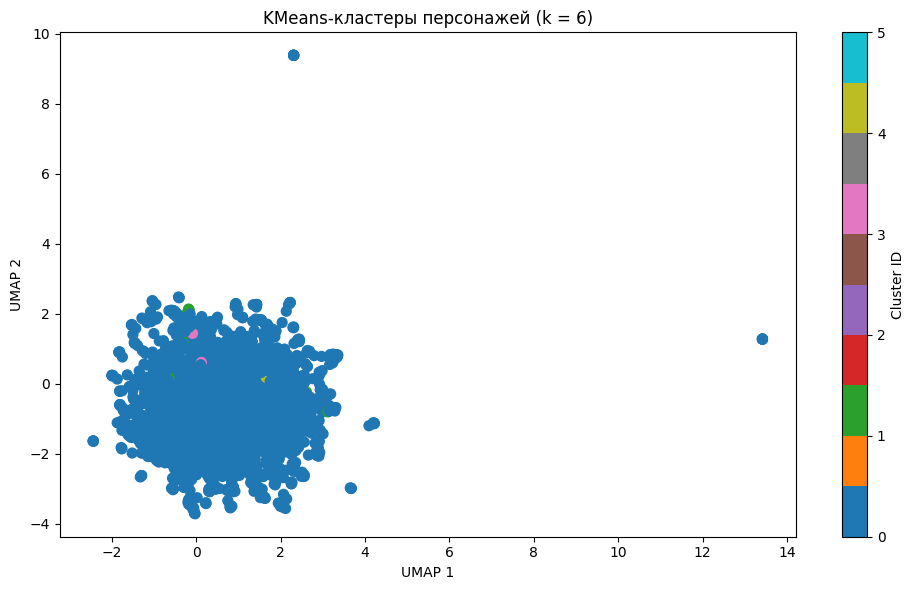

In [170]:
cluster_characters_kmeans(
    profile_path="character_profiles_agg.json",
    output_csv="character_clusters_kmeans.csv",
    n_clusters=6  # можно пробовать 6, 8, 10...
)

In [171]:
summarize_cluster_behaviors(
    cluster_csv="character_clusters_kmeans.csv",
    profiles_json="character_profiles_agg.json",
    top_n=100
)


=== 🔎 Кластер 0 (персонажей: 2872) ===
📌 Итого по кластеру 0: 11983 глаголов, 5135 прил., 2299 наречий

=== 🔎 Кластер 2 (персонажей: 1) ===
📌 Итого по кластеру 2: 12 глаголов, 5 прил., 4 наречий

=== 🔎 Кластер 5 (персонажей: 2) ===
📌 Итого по кластеру 5: 54 глаголов, 16 прил., 9 наречий

=== 🔎 Кластер 1 (персонажей: 9) ===
📌 Итого по кластеру 1: 97 глаголов, 49 прил., 9 наречий

=== 🔎 Кластер 3 (персонажей: 2) ===
📌 Итого по кластеру 3: 30 глаголов, 13 прил., 4 наречий

=== 🔎 Кластер 4 (персонажей: 1) ===
📌 Итого по кластеру 4: 17 глаголов, 8 прил., 4 наречий

🧠 Кластер 0 (персонажей: 2872)
  🔹 Глаголы      : 发现、离开、摇头、喜欢、拜托、点头、回头、无法、传来、注意、发生、抬头、感觉、收藏、伸手、微笑、露出、看来、下去、反应
  🔹 Прилагательные: 清楚、简单、不好、安静、显然、年轻、平静、沉默、确实、容易、小心、重要、厉害、普通、高兴、明显、明白、仔细、奇怪、正常
  🔹 Наречия      : 居然、微微、不要、几乎、一边、根本、轻轻、刚才、慢慢、毕竟、依然、重新、真正、不见、同样、正在、也许、渐渐、到底、更加

🧠 Кластер 1 (персонажей: 9)
  🔹 Глаголы      : 结束、赐婚、醉意、相连、担心、流动、守卫、裂口、无事、发现、归来、喜服、没事、淬炼、流逝、陪伴、敬酒、簪子、熏熏、出场
  🔹 Прилагательные: 广漠王、严谨、大红、孤独、悬殊、柔道、残忍、大神、全职、淡淡、羸弱、腼

## HDBSCAN

In [172]:
def cluster_characters_hdbscan(profile_path="character_profiles_agg.json", output_csv="character_clusters_hdbscan.csv", min_cluster_size=5):
    # Загрузка профилей
    with open(profile_path, encoding='utf-8') as f:
        profiles = json.load(f)

    characters = []
    verbs_texts = []
    adjs_texts = []
    advs_texts = []

    for name, data in profiles.items():
        characters.append(name)
        verbs_texts.append(" ".join(data["features"].get("verbs", [])))
        adjs_texts.append(" ".join(data["features"].get("adjs", [])))
        advs_texts.append(" ".join(data["features"].get("advs", [])))

    # Отдельные TF-IDF-векторизаторы
    v_verb = TfidfVectorizer()
    v_adj = TfidfVectorizer()
    v_adv = TfidfVectorizer()

    X_verbs = v_verb.fit_transform(verbs_texts)
    X_adjs = v_adj.fit_transform(adjs_texts)
    X_advs = v_adv.fit_transform(advs_texts)

    # Объединённая матрица признаков
    X = hstack([X_verbs, X_adjs, X_advs])

    # Кластеризация
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)
    labels = clusterer.fit_predict(X.toarray())

    # Визуализация UMAP
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X.toarray())

    # Таблица результатов
    df = pd.DataFrame({
        "character": characters,
        "cluster": labels,
        "x": embedding[:, 0],
        "y": embedding[:, 1]
    })
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"✅ Кластеры сохранены в {output_csv}")

    # Отображение графика
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["cluster"], cmap="tab10", s=50)
    plt.title("Кластеры персонажей (HDBSCAN + TF-IDF)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()

d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Кластеры сохранены в character_clusters_hdbscan.csv


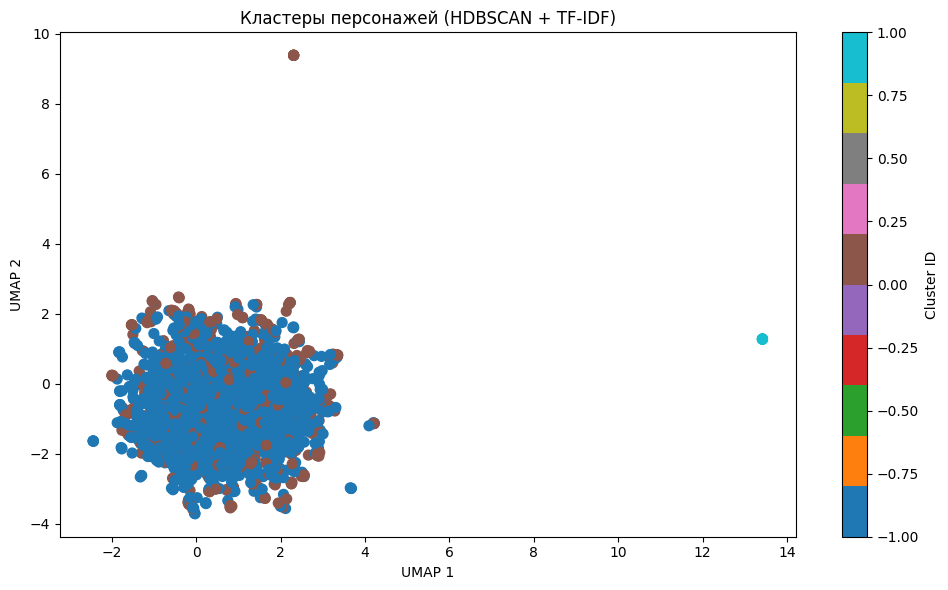

In [173]:
cluster_characters_hdbscan(profile_path=r"character_profiles_agg.json")

In [174]:
hdf = pd.read_csv(r'character_clusters_hdbscan.csv')
hdf

,character,cluster,x,y
0,燕绥之,-1,0.889475,-1.362479
1,阮野,-1,0.654609,-0.523655
2,德卡马,-1,0.500835,-0.461938
3,金,0,0.355246,0.294809
4,燕,0,0.388643,0.252899
...,...,...,...,...
2882,张春龄,-1,-0.679066,0.124985
2883,卫兰,-1,0.616215,-2.646666
2884,余斌,-1,-0.426061,-2.707055
2885,钱程,-1,-0.508036,-2.764824


In [175]:
summarize_cluster_behaviors('character_clusters_hdbscan.csv', 'character_profiles_agg.json')


=== 🔎 Кластер -1 (персонажей: 2332) ===
📌 Итого по кластеру -1: 10947 глаголов, 4749 прил., 2148 наречий

=== 🔎 Кластер 0 (персонажей: 549) ===
📌 Итого по кластеру 0: 3783 глаголов, 1374 прил., 600 наречий

=== 🔎 Кластер 1 (персонажей: 6) ===
📌 Итого по кластеру 1: 26 глаголов, 5 прил., 3 наречий

🧠 Кластер -1 (персонажей: 2332)
  🔹 Глаголы      : 发现、离开、摇头、喜欢、回头、拜托、传来、点头、抬头、无法、看来、注意、下去、微笑、露出、伸手、感觉、发生、打算、反应
  🔹 Прилагательные: 清楚、不好、简单、平静、容易、确实、沉默、重要、安静、显然、小心、明白、高兴、普通、年轻、明显、奇怪、仔细、认真、紧张
  🔹 Наречия      : 微微、居然、几乎、不要、根本、一边、毕竟、慢慢、刚才、重新、真正、正在、同样、依然、更加、渐渐、也许、绝对、缓缓、顿时

🧠 Кластер 0 (персонажей: 549)
  🔹 Глаголы      : 发现、拜托、收藏、点头、离开、摇头、发生、反应、感觉、排行、喜欢、伸手、无法、进入、使用、注意、回头、到底、看看、打量
  🔹 Прилагательные: 清楚、厉害、年轻、安静、显然、正常、好奇、温和、惊讶、简单、小心、麻烦、普通、明显、少年、古老、热闹、沉默、仔细、神秘
  🔹 Наречия      : 轻轻、居然、刚刚、一边、不要、刚才、微微、不见、几乎、依然、重新、慢慢、到底、也许、真正、毕竟、同样、相当、根本、渐渐

🧠 Кластер 1 (персонажей: 6)
  🔹 Глаголы      : 进行、轮回、守护、使者、平分、考虑、断断、领先、休息、上阵、刺客、分值、削弱、共计、相反、组队、续续、牧师职业、治疗职业、附加
  🔹 Прилагательные: 平分、狂剑士、柔道职业、容易、柔道
  🔹 Наречия

## Пытаемся прокластеризовать шумовой кластер

In [181]:
df = pd.read_csv("character_clusters_hdbscan.csv")
cluster_minus1 = df[df["cluster"] == -1]
cluster_minus1

,character,cluster,x,y
0,燕绥之,-1,0.889475,-1.362479
1,阮野,-1,0.654609,-0.523655
2,德卡马,-1,0.500835,-0.461938
5,顾晏,-1,0.612043,-0.092275
6,顾,-1,0.390341,-0.386575
...,...,...,...,...
2882,张春龄,-1,-0.679066,0.124985
2883,卫兰,-1,0.616215,-2.646666
2884,余斌,-1,-0.426061,-2.707055
2885,钱程,-1,-0.508036,-2.764824


In [182]:
with open("character_profiles_agg.json", "r", encoding="utf-8") as f:
    profiles = json.load(f)
    
filtered_profiles = {
    char: data for char, data in profiles.items() if char in cluster_minus1["character"].values
}

In [183]:
len(filtered_profiles)

2332

d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


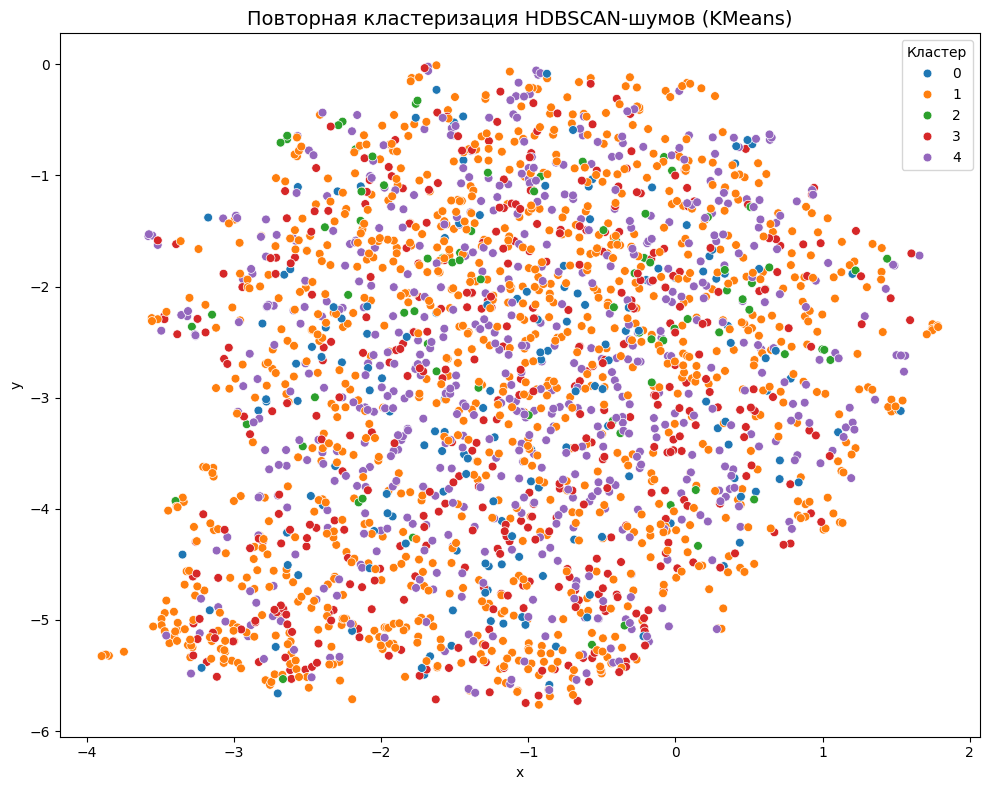

In [188]:
import seaborn as sns
# Собираем признаки
def profile_to_text(profile):
    feats = []
    for cat in ["verbs", "adjs", "advs"]:
        feats.extend(profile["features"].get(cat, []))
    return " ".join(feats)

texts = [profile_to_text(filtered_profiles[char]) for char in filtered_profiles]
names = list(filtered_profiles.keys())

# Векторизация
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# Кластеризация
k = 5  # можно варьировать
model = KMeans(n_clusters=k, random_state=42)
labels = model.fit_predict(X)

# Результат
results = pd.DataFrame({
    "canonical": names,
    "cluster_kmeans": labels
})
# results.to_csv("cluster_minus1_reclustered.csv", index=False, encoding="utf-8-sig")

# UMAP проекция
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Визуализация
results["x"] = embedding[:, 0]
results["y"] = embedding[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=results,
    x="x", y="y",
    hue="cluster_kmeans",
    palette="tab10",
    s=40
)
plt.title("Повторная кластеризация HDBSCAN-шумов (KMeans)", fontsize=14)
plt.legend(title="Кластер")
plt.tight_layout()
plt.show()

In [185]:
results

,canonical,cluster_kmeans
0,燕绥之,1
1,阮野,3
2,德卡马,1
3,顾晏,1
4,顾,4
...,...,...
2327,张春龄,1
2328,卫兰,4
2329,余斌,1
2330,钱程,4


In [190]:
def summarize_cluster_behaviors_again(profiles, cluster_df, label_column="cluster_kmeans", top_n=20):
    cluster_groups = cluster_df.groupby(label_column)

    for cluster_id, group in cluster_groups:
        verbs, adjs, advs = Counter(), Counter(), Counter()
        for canonical in group["canonical"]:
            feats = profiles.get(canonical, {}).get("features", {})
            verbs.update(feats.get("verbs", []))
            adjs.update(feats.get("adjs", []))
            advs.update(feats.get("advs", []))
        
        print(f"\n🧠 Кластер {cluster_id} (персонажей: {len(group)})")
        print("  🔹 Глаголы      :", "、".join([w for w, _ in verbs.most_common(top_n)]))
        print("  🔹 Прилагательные:", "、".join([w for w, _ in adjs.most_common(top_n)]))
        print("  🔹 Наречия      :", "、".join([w for w, _ in advs.most_common(top_n)]))

summarize_cluster_behaviors_again(filtered_profiles, results)


🧠 Кластер 0 (персонажей: 162)
  🔹 Глаголы      : 发现、猜测、证明、感谢、看来、喜欢、离开、提起、传来、微笑、存在、回头、放心、汇报、伸手、收藏、露出、遇到、回到、拜托
  🔹 Прилагательные: 不行、麻烦、容易、愉快、清楚、明白、平静、奇怪、安静、努力、不好、普通、高兴、小心、迅速、漂亮、认真、清晰、确实、惊讶
  🔹 Наречия      : 居然、微微、不要、几乎、渐渐、根本、也许、慢慢、毕竟、不行、绝对、重新、本来、足以、一边、到底、从来、更加、顿时、当初

🧠 Кластер 1 (персонажей: 1053)
  🔹 Глаголы      : 发现、摇头、喜欢、拜托、点头、传来、微笑、看来、注意、收藏、抬头、发生、回头、无法、打量、露出、安排、希望、熟悉、进入
  🔹 Прилагательные: 清楚、不好、简单、仔细、平静、年轻、沉默、小心、高兴、安静、容易、厉害、正式、明白、确实、重要、普通、干净、具体、陌生
  🔹 Наречия      : 微微、居然、不要、几乎、根本、毕竟、一边、同样、慢慢、重新、相当、缓缓、不见、真正、渐渐、正在、依然、恐怕、究竟、绝对

🧠 Кластер 2 (персонажей: 80)
  🔹 Глаголы      : 回头、传来、维护、离开、联姻、皱眉、喜欢、忠心、晓得、下去、摇头、发现、看来、抬头、可惜、颤抖、传说、打算、怀里、无法
  🔹 Прилагательные: 狼狈、近来、明白、慢条、清楚、确实、茫然、尴尬、普通、激动、平静、清晰、聪明、合适、小声、小子、剧烈、高明、忠心、混沌
  🔹 Наречия      : 不准、一心、微微、正好、居然、一向、尽量、毕竟、依然、更加、从来、本来、从未、只得、不及、究竟、大声、不用、最后、同样

🧠 Кластер 3 (персонажей: 416)
  🔹 Глаголы      : 下去、打算、发现、离开、习惯、理解、摇头、估计、拜托、发生、无法、伸手、露出、属于、传来、得到、点头、注意、跟着、算是
  🔹 Прилагательные: 显然、明显、简单、清楚、正常、沉重、艰难、重要、平静、容易、沉默、确实、不好、年轻、认真、狰狞、勉强、紧张、轻松、仔细
  🔹

# Экспериментируем с новыми паттернами

In [ ]:
from ltp import LTP

ltp = LTP()

def extract_features_with_dependencies(text, stopwords=stopwords):
    features = {
        "verbs": [],
        "adjs": [],
        "advs": [],
        "adv_verb": [],
        "verb_obj": [],
        "adj_verb": []
    }

    sentences = split_into_sentences(text)

    for sent in sentences:
        pipe = ltp.pipeline([sent], tasks=["cws", "pos", "dep"])
        tokens = pipe.cws[0]
        pos_tags = pipe.pos[0]
        dep_info = pipe.dep[0]  # словарь: {'head': [...], 'label': [...]}

        for word, tag in zip(tokens, pos_tags):
            if word in stopwords or not (1 < len(word) < 8):
                continue
            if tag.startswith("v"):
                features["verbs"].append(word)
            elif tag.startswith("a"):
                features["adjs"].append(word)
            elif tag == "d":
                features["advs"].append(word)

        for dep_idx, (head_idx, rel) in enumerate(zip(dep_info['head'], dep_info['label'])):
            if head_idx == 0:
                continue  # пропускаем связи с root

            head_word = tokens[head_idx - 1]
            dep_word = tokens[dep_idx]
            head_tag = pos_tags[head_idx - 1]
            dep_tag = pos_tags[dep_idx]

            if dep_word in stopwords or head_word in stopwords:
                continue

            if rel == "ADV" and dep_tag == "d" and head_tag.startswith("v"):
                features["adv_verb"].append(f"{dep_word}+{head_word}")

            if rel == "VOB" and head_tag.startswith("v") and dep_tag.startswith("n"):
                features["verb_obj"].append(f"{head_word}+{dep_word}")

            if dep_tag.startswith("a") and head_tag.startswith("v"):
                features["adj_verb"].append(f"{dep_word}+{head_word}")

    for k in features:
        features[k] = Counter(features[k])

    return features

In [213]:
doc = all_data[1]['context']
# print(doc)
extract_features_with_dependencies(doc)

{'verbs': Counter({'帮忙': 2,
          '适合': 1,
          '打家劫舍': 1,
          '送终': 1,
          '担任': 1,
          '参加': 1,
          '聚集': 1,
          '扫视': 1,
          '嫌弃': 1,
          '显示': 1,
          '感受': 1,
          '变形': 1,
          '习惯': 1,
          '方便': 1,
          '携带': 1,
          '配适': 1,
          '可怜': 1,
          '出厂': 1,
          '合成': 1}),
 'adjs': Counter({'混乱': 1,
          '黑市区': 1,
          '拥挤': 1,
          '好看': 1,
          '浓重': 1,
          '精磨': 1,
          '合适': 1,
          '窄小': 1,
          '随意': 1,
          '清奇': 1,
          '干净': 1}),
 'advs': Counter({'一边': 2, '素白': 1, '最好': 1, '总共': 1}),
 'adv_verb': Counter({'一边+喝': 1, '一边+扫视': 1, '更+习惯': 1}),
 'verb_obj': Counter({'衬+心情': 1,
          '顶+头衔': 1,
          '担任+职': 1,
          '参加+酒会': 1,
          '喝+咖啡': 1,
          '扫视+标牌': 1,
          '查+东西': 1,
          '办+假证': 1,
          '显示+字': 1,
          '捏+咖啡杯': 1,
          '抬+脚': 1,
          '顶+鸡窝头': 1,
          '探+脑袋': 1,
    

In [ ]:
def build_profiles_top_characters_extended(jsonl_path, stopwords, top_n_characters=1000, max_contexts=300, min_mentions=10):
    # подсчет частот персонажей
    char_freq = defaultdict(int)
    character_contexts = defaultdict(list)

    with open(jsonl_path, encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            data = json.loads(line)
            canonical = data["canonical"]
            character_contexts[canonical].append(data["context"])
            char_freq[canonical] += 1

    top_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)[:top_n_characters]
    top_chars_set = set([c for c, _ in top_chars])

    print(f"Обрабатываем {len(top_chars_set)} самых частотных персонажей...")

    profiles = {}

    for name in tqdm(top_chars_set, desc="Извлечение признаков"):
        contexts = character_contexts[name]
        if len(contexts) < min_mentions:
            continue

        limited_contexts = contexts[:max_contexts]
        combined_text = " ".join(limited_contexts)

        feats = extract_features_with_dependencies(combined_text, stopwords)

        profiles[name] = feats

    with open("character_profiles_top1000.json", "w", encoding="utf-8") as f:
        json.dump(profiles, f, ensure_ascii=False, indent=2)

    print(f"✅ Сохранено {len(profiles)} поведенческих профилей в character_profiles_top1000.json")

In [231]:
json_path = r'character_mentions_21sent.jsonl'
build_profiles_top_characters_extended(json_path, stopwords)

🚀 Обрабатываем 1000 самых частотных персонажей...


🔍 Извлечение признаков: 100%|██████████| 1000/1000 [50:08:53<00:00, 180.53s/it]      


✅ Сохранено 1000 поведенческих профилей в character_profiles_top1000.json


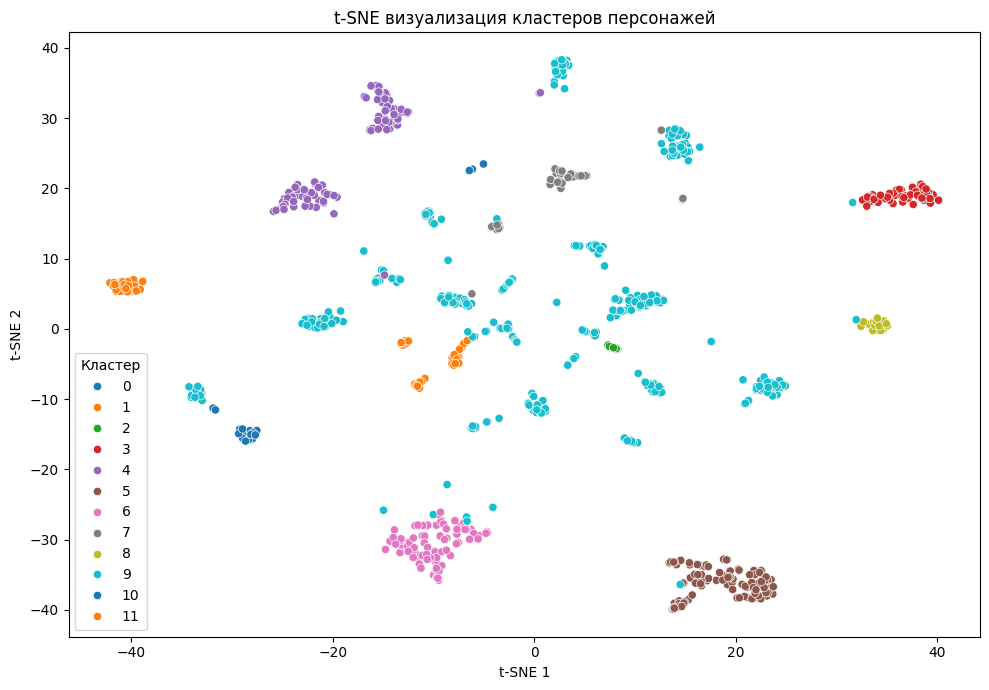

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

with open("character_profiles_top1000.json", encoding="utf-8") as f:
    profiles = json.load(f)

texts = []
names = []
for name, feats in profiles.items():
    tokens = []
    for cat in ['verbs', 'adjs', 'advs', 'verb_obj', 'adv_verb', 'adj_verb']:
        if cat in feats:
            for word, freq in feats[cat].items():
                tokens.extend([word] * freq)
    if tokens:
        texts.append(" ".join(tokens))
        names.append(name)

vectorizer = TfidfVectorizer(max_df=0.65, min_df=10)
X_tfidf = vectorizer.fit_transform(texts)

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

kmeans = KMeans(n_clusters=12, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df = pd.DataFrame({
    "name": names,
    "cluster": labels,
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1]
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10")
plt.title("t-SNE визуализация кластеров персонажей")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Кластер")
plt.tight_layout()
plt.show()

In [9]:
def summarize_clusters(df, profiles, top_n=10):
    cluster_features = defaultdict(lambda: defaultdict(Counter))

    for _, row in df.iterrows():
        name = row["name"]
        cluster = row["cluster"]
        feats = profiles.get(name, {})
        for cat in ["verbs", "adjs", "advs", "verb_obj", "adv_verb", "adj_verb"]:
            if cat in feats:
                for word, freq in feats[cat].items():
                    cluster_features[cluster][cat][word] += freq

    summaries = {}
    for cluster, cats in cluster_features.items():
        summary = {cat: [w for w, _ in cats[cat].most_common(top_n)] for cat in cats}
        summaries[cluster] = summary

    return summaries

In [10]:
summaries = summarize_clusters(df, profiles, top_n=20)
# summaries

{9: {'verbs': ['发现',
   '喜欢',
   '下去',
   '看看',
   '离开',
   '跟着',
   '伸手',
   '点头',
   '忍不住',
   '反应',
   '想起',
   '进去',
   '露出',
   '开口',
   '回头',
   '发生',
   '只能',
   '明白',
   '感觉',
   '传来'],
  'adjs': ['不好',
   '清楚',
   '沉默',
   '确实',
   '轻淼',
   '高兴',
   '厉害',
   '平静',
   '容易',
   '重要',
   '仔细',
   '简单',
   '安静',
   '小心',
   '显然',
   '明白',
   '年轻',
   '不对',
   '惊讶',
   '紧张'],
  'advs': ['一边',
   '居然',
   '不要',
   '微微',
   '到底',
   '几乎',
   '根本',
   '倒是',
   '轻轻',
   '慢慢',
   '不用',
   '连忙',
   '本来',
   '毕竟',
   '好好',
   '低声',
   '顿时',
   '赶紧',
   '正在',
   '缓缓'],
  'verb_obj': ['叹+气',
   '点点+头',
   '摇摇+头',
   '抬+头',
   '皱+眉',
   '睁+眼',
   '低+头',
   '抬+手',
   '松+气',
   '抬+眼',
   '闻+人厄',
   '战+北野',
   '点+头',
   '吸+气',
   '伸出+手',
   '睁+眼睛',
   '转+身',
   '闭+眼睛',
   '闭+眼',
   '含+雪'],
  'adv_verb': ['低声+道',
   '深+吸',
   '紧+绷',
   '不用+担心',
   '淡淡+道',
   '便+道',
   '相+助',
   '缓缓+道',
   '紧+闭',
   '厉声+道',
   '轻轻+道',
   '嚎啕+哭',
   '狠狠+瞪',
   '大声+道',
   '乱+跑',
   '岂+料',
   '略+显',
   '到底+发生',
   '